In [11]:
import numpy.random
import matplotlib.pyplot as plt
from kendall import KendallSimulator, KendallServer, KendallEvent
from kendall.queues import RandomServerQueue
from kendall.spawners import ExponentialSpawner


def average(list):
    return sum(list) / float(len(list))


class TelephoneLine(KendallServer):
    def __init__(self, queue, id):
        self.queue = queue
        self.id = id
        self.reset()

    def assign(self, event, time):
        self.event = event
        self.start_time = time

    def complete(self, event, time):
        self.event = None
        self.total_time += time - self.start_time
        self.start_time = None

    def reset(self):
        self.event = None
        self.start_time = None
        self.total_time = 0.00


class CallEvent(KendallEvent):
    average_call_duration = 300.0
    count = 0
    dropped = 0
    last_spawn_time = 0.0
    spawn_delays = []
    call_durations = []

    def __init__(self, *args, **kwargs):
        super(CallEvent, self).__init__(*args, **kwargs)
        CallEvent.count += 1
        self.count = CallEvent.count
        self._processing_time = numpy.random.exponential(CallEvent.average_call_duration)

    def on_enqueue(self, queue, time):
        self.enter_time = time
        CallEvent.spawn_delays.append(time - CallEvent.last_spawn_time)
        CallEvent.call_durations.append(self._processing_time)
        CallEvent.last_spawn_time = time
        # print "Ship {} entered harbor at {}! Current queue: {}".format(self.count, time, len(queue.queue))

    def on_drop(self, queue, time):
        CallEvent.dropped += 1
        # print "Call {} was dropped at {}!".format(self.count, time)

    def on_process(self, server, time):
        # print "Call {} was started at {}!".format(self.count, time)
        pass

    def on_finish(self, queue, time):
        self.exit_time = time
        # print "Call {} was finished at {}!".format(self.count, time)

    def processing_time(self, server):
        return self._processing_time


class TelephoneSystem(RandomServerQueue):
    server_class = TelephoneLine


class CallSpawner(ExponentialSpawner):
    pipe_event_class = CallEvent


class AsymmetricTelephonySimulator(KendallSimulator):
    def __init__(self, time_limit, a_to_b_lines, b_to_a_lines):
        super(AsymmetricTelephonySimulator, self).__init__(time_limit)

        self.city_a_spawner = CallSpawner(self, 12.0)
        self.city_b_spawner = CallSpawner(self, 15.0)
        self.a_to_b_system = TelephoneSystem(self, server_count=a_to_b_lines, max_queued=0)
        self.b_to_a_system = TelephoneSystem(self, server_count=b_to_a_lines, max_queued=0)

        self.register_queue("City A Spawner", self.city_a_spawner)
        self.register_queue("City B Spawner", self.city_b_spawner)
        self.register_queue("A to B System", self.a_to_b_system)
        self.register_queue("B to A System", self.b_to_a_system)
        self.city_a_spawner.pipe(self.a_to_b_system)
        self.city_b_spawner.pipe(self.b_to_a_system)

        self.all_spawn_delays = []
        self.all_call_durations = []
        self.all_dropped_percentages = []
        self.all_minimums = []
        self.all_averages = []
        self.all_maximums = []

    def reset(self):
        super(AsymmetricTelephonySimulator, self).reset()
        self.city_a_spawner.start()
        self.city_b_spawner.start()
        CallEvent.count = 0
        CallEvent.dropped = 0
        CallEvent.last_spawn_time = 0.0
        CallEvent.spawn_delays = []
        CallEvent.call_durations = []

    def collect(self):
        minimum = min(CallEvent.call_durations)
        average = sum(CallEvent.call_durations) / len(CallEvent.call_durations)
        maximum = max(CallEvent.call_durations)

        self.all_spawn_delays.extend(CallEvent.spawn_delays)
        self.all_call_durations.extend(CallEvent.call_durations)
        self.all_minimums.append(minimum)
        self.all_maximums.append(maximum)
        self.all_averages.append(average)
        self.all_dropped_percentages.append(CallEvent.dropped / float(CallEvent.count))


class SymmetricTelephonySimulator(KendallSimulator):
    def __init__(self, time_limit, total_lines):
        super(SymmetricTelephonySimulator, self).__init__(time_limit)

        self.city_a_spawner = CallSpawner(self, 12.0)
        self.city_b_spawner = CallSpawner(self, 15.0)
        self.symmetric_system = TelephoneSystem(self, server_count=total_lines, max_queued=0)

        self.register_queue("City A Spawner", self.city_a_spawner)
        self.register_queue("City B Spawner", self.city_b_spawner)
        self.register_queue("Symmetric System", self.symmetric_system)
        self.city_a_spawner.pipe(self.symmetric_system)
        self.city_b_spawner.pipe(self.symmetric_system)

        self.all_spawn_delays = []
        self.all_call_durations = []
        self.all_dropped_percentages = []
        self.all_minimums = []
        self.all_averages = []
        self.all_maximums = []

    def reset(self):
        super(SymmetricTelephonySimulator, self).reset()
        self.city_a_spawner.start()
        self.city_b_spawner.start()
        CallEvent.count = 0
        CallEvent.dropped = 0
        CallEvent.last_spawn_time = 0.0
        CallEvent.spawn_delays = []
        CallEvent.call_durations = []

    def collect(self):
        minimum = min(CallEvent.call_durations)
        average = sum(CallEvent.call_durations) / len(CallEvent.call_durations)
        maximum = max(CallEvent.call_durations)

        self.all_spawn_delays.extend(CallEvent.spawn_delays)
        self.all_call_durations.extend(CallEvent.call_durations)
        self.all_minimums.append(minimum)
        self.all_maximums.append(maximum)
        self.all_averages.append(average)
        self.all_dropped_percentages.append(CallEvent.dropped / float(CallEvent.count))


In [25]:
def test_asymmetric(runs=1000, time_limit=3000, a_to_b=10, b_to_a=10):
    sim = AsymmetricTelephonySimulator(time_limit, a_to_b, b_to_a)
    for x in xrange(0, runs):
        sim.reset()
        sim.run()
        sim.collect()

    plt.title("Percent dropped calls with {} X to Y and {} Y to X lines".format(a_to_b, b_to_a))
    plt.hist(sim.all_dropped_percentages, range=[0.0, 1.0], bins='auto', edgecolor="blue")
    plt.show()

    print "Average call drop percentage:", average(sim.all_dropped_percentages)

    good_runs = [x for x in sim.all_dropped_percentages if x < 0.05]
    print "Percent call drop percentage below 5%: {}".format(len(good_runs) / float(runs))

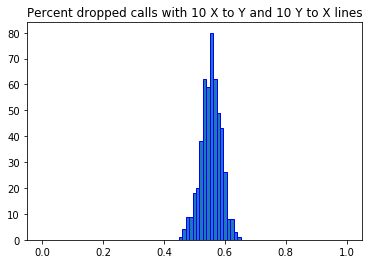

Average call drop percentage: 0.553543163887
Percent call drop percentage below 5%: 0.0


In [26]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=10, b_to_a=10)

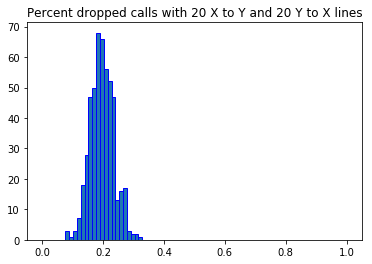

Average call drop percentage: 0.195947115889
Percent call drop percentage below 5%: 0.0


In [27]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=20, b_to_a=20)

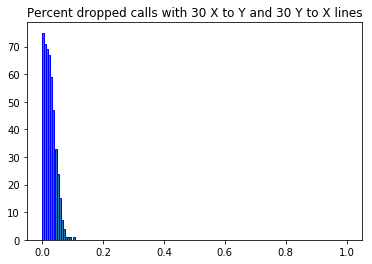

Average call drop percentage: 0.0248897974307
Percent call drop percentage below 5%: 0.892


In [33]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=30, b_to_a=30)

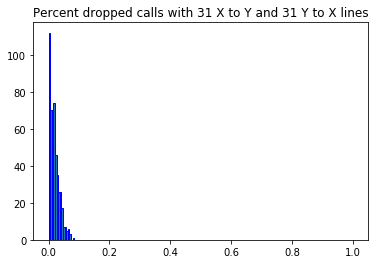

Average call drop percentage: 0.0189486190553
Percent call drop percentage below 5%: 0.946


In [76]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=31, b_to_a=31)

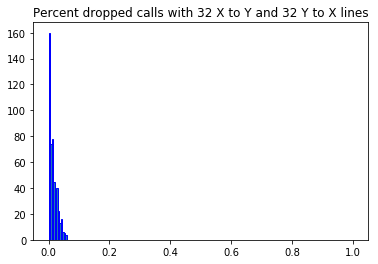

Average call drop percentage: 0.0143079426784
Percent call drop percentage below 5%: 0.982


In [31]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=32, b_to_a=32)

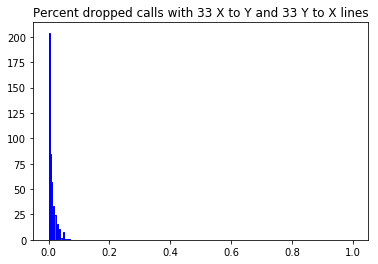

Average call drop percentage: 0.00993040237434
Percent call drop percentage below 5%: 0.99


In [45]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=33, b_to_a=33)

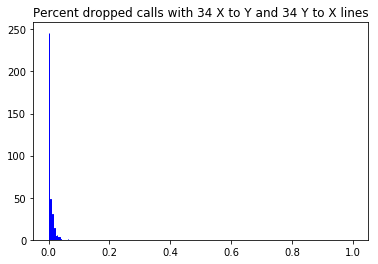

Average call drop percentage: 0.00599931145257
Percent call drop percentage below 5%: 0.998


In [46]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=34, b_to_a=34)

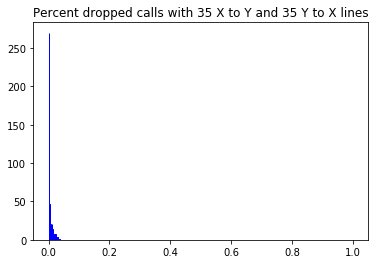

Average call drop percentage: 0.00465374732741
Percent call drop percentage below 5%: 1.0


In [58]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=35, b_to_a=35)

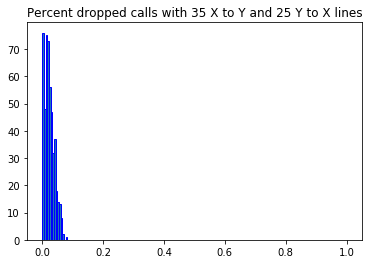

Average call drop percentage: 0.0230949275239
Percent call drop percentage below 5%: 0.926


In [60]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=35, b_to_a=25)

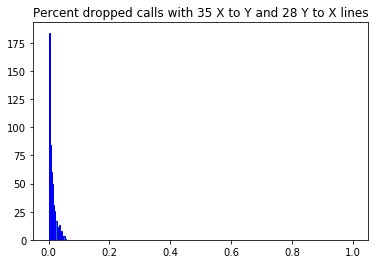

Average call drop percentage: 0.0100623192134
Percent call drop percentage below 5%: 0.992


In [59]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=35, b_to_a=28)

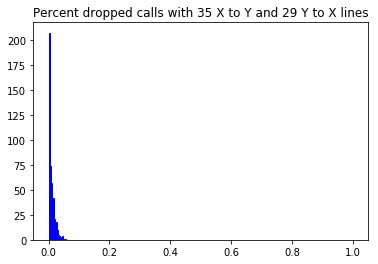

Average call drop percentage: 0.00828563028561
Percent call drop percentage below 5%: 0.998


In [61]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=35, b_to_a=29)

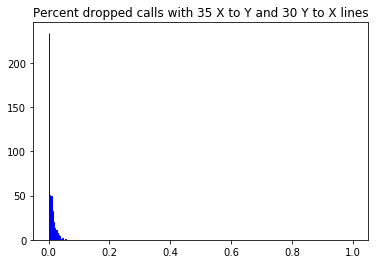

Average call drop percentage: 0.00741644649
Percent call drop percentage below 5%: 0.998


In [62]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=35, b_to_a=30)

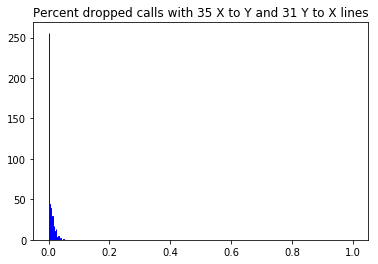

Average call drop percentage: 0.00613414733274
Percent call drop percentage below 5%: 1.0


In [63]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=35, b_to_a=31)

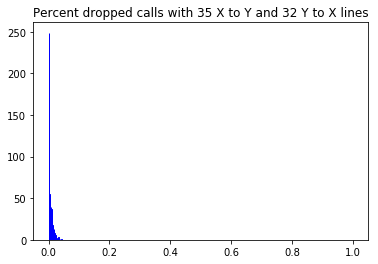

Average call drop percentage: 0.00504651459364
Percent call drop percentage below 5%: 1.0


In [64]:
test_asymmetric(runs=500, time_limit=3000, a_to_b=35, b_to_a=32)

In [65]:
def test_symmetric(runs=1000, time_limit=3000, total_lines=10):
    sim = SymmetricTelephonySimulator(time_limit, total_lines)
    for x in xrange(0, runs):
        sim.reset()
        sim.run()
        sim.collect()

    plt.title("Percent dropped calls with {} lines".format(total_lines))
    plt.hist(sim.all_dropped_percentages, range=[0.0, 1.0], bins='auto', edgecolor="blue")
    plt.show()

    print "Average call drop percentage:", average(sim.all_dropped_percentages)

    good_runs = [x for x in sim.all_dropped_percentages if x < 0.05]
    print "Percent call drop percentage below 5%: {}".format(len(good_runs) / float(runs))

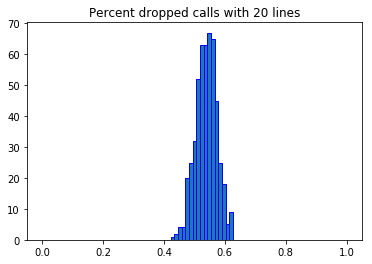

Average call drop percentage: 0.538053923603
Percent call drop percentage below 5%: 0.0


In [66]:
test_symmetric(runs=500, time_limit=3000, total_lines=20)

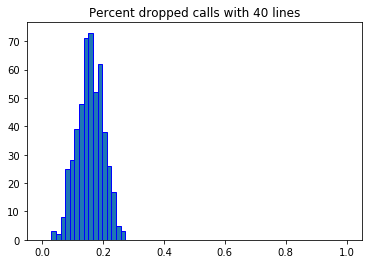

Average call drop percentage: 0.1567737724
Percent call drop percentage below 5%: 0.008


In [67]:
test_symmetric(runs=500, time_limit=3000, total_lines=40)

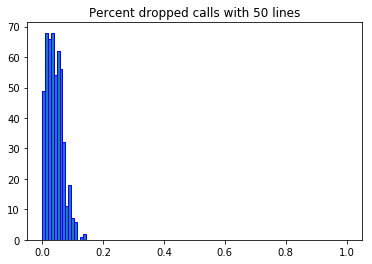

Average call drop percentage: 0.0409638046235
Percent call drop percentage below 5%: 0.65


In [68]:
test_symmetric(runs=500, time_limit=3000, total_lines=50)

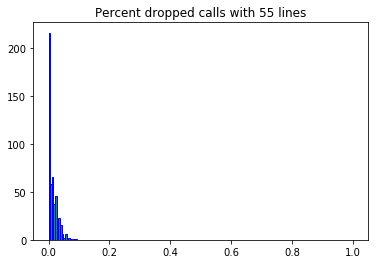

Average call drop percentage: 0.013122149359
Percent call drop percentage below 5%: 0.972


In [70]:
test_symmetric(runs=500, time_limit=3000, total_lines=55)

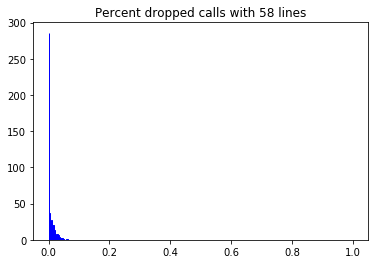

Average call drop percentage: 0.0067841012944
Percent call drop percentage below 5%: 0.994


In [71]:
test_symmetric(runs=500, time_limit=3000, total_lines=58)

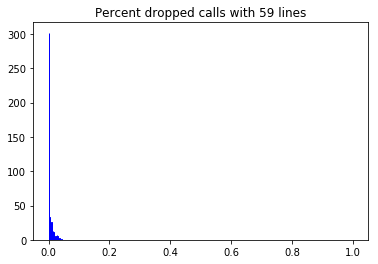

Average call drop percentage: 0.00444864461402
Percent call drop percentage below 5%: 1.0


In [75]:
test_symmetric(runs=500, time_limit=3000, total_lines=59)

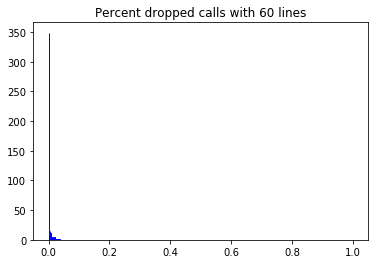

Average call drop percentage: 0.00311414867592
Percent call drop percentage below 5%: 1.0


In [74]:
test_symmetric(runs=500, time_limit=3000, total_lines=60)